# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [2]:
mode_train = True

In [177]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr_tcn"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [4]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [5]:
get_data_pos()
df_feat_fr = load_data_pos()

Must load more last days, 25 days missing
['2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04']
2021-01-11: 474 records
2021-01-12: 470 records
2021-01-13: 473 records
2021-01-14: 478 records
2021-01-15: 480 records
2021-01-16: 482 records
2021-01-17: 482 records
2021-01-18: 479 records
2021-01-19: 479 records
2021-01-20: 480 records
2021-01-21: 474 records
2021-01-22: 480 records
2021-01-23: 475 records
2021-01-24: 477 records
2021-01-25: 476 records
2021-01-26: 472 records
2021-01-27: 468 records
2021-01-28: 467 records
2021-01-29: 461 records
2021-01-30: 460 records
2021-01-31: 468 records
2021-02-01: 472 records
2021-02-02: 467 records
2021-02-03: 470 records
2021-02-04: 477 records
11841 r

## Retrieve old data

In [6]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [7]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-01-31  283.925000  2021-01-31  288.071667  76.833333  91.816667     0.0   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-01-31   3368  51.137767   44079  49.831167        0   3148636   284658.0   
2021-02-01  31727  48.570681  442330  48.834680        1   3180363   285741.0   
2021-02-02  24200  48.406736  384619  47.749391        2   3204563   285920.0   
2021-02-03  21804  46.978307  349340  46.935510        3   3226367   285098.0   
2021-02-04  21381  47.662644  374503  46.107908        4   3247748   283386.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.256198  
2020-05-14       NaN  2.331730  
2020-05-15       NaN  2.141090  
2020-05-16       NaN  1.759903  
2020-05-17       NaN  2.104785  
...              ...       ...  
2021-01-31  1.115650  7.640827  
2021-02-01  1.111893  7.172699  
2021-02-02  1.108234  6.291941  
2021-02-03  1.095448  6.241484  
2021-02-04  1.074832  5.709167  

[268 rows x 15 columns]

In [8]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 254


In [9]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-01-31  283.925000  2021-01-31  288.071667  76.833333  91.816667     0.0   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-01-31   3368  51.137767   44079  49.831167        0   3148636   284658.0   
2021-02-01  31727  48.570681  442330  48.834680        1   3180363   285741.0   
2021-02-02  24200  48.406736  384619  47.749391        2   3204563   285920.0   
2021-02-03  21804  46.978307  349340  46.935510        3   3226367   285098.0   
2021-02-04  21381  47.662644  374503  46.107908        4   3247748   283386.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.256198   True  
2020-05-14       NaN  2.331730   True  
2020-05-15       NaN  2.141090   True  
2020-05-16       NaN  1.759903   True  
2020-05-17       NaN  2.104785   True  
...              ...       ...    ...  
2021-01-31  1.115650  7.640827  False  
2021-02-01  1.111893  7.172699  False  
2021-02-02  1.108234  6.291941  False  
2021-02-03  1.095448  6.241484  False  
2021-02-04  1.074832  5.709167  False  

[268 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

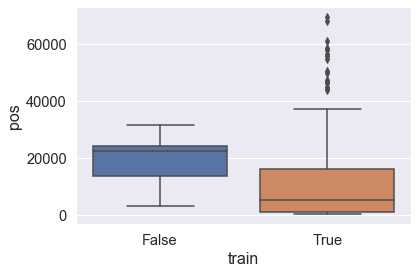

In [10]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

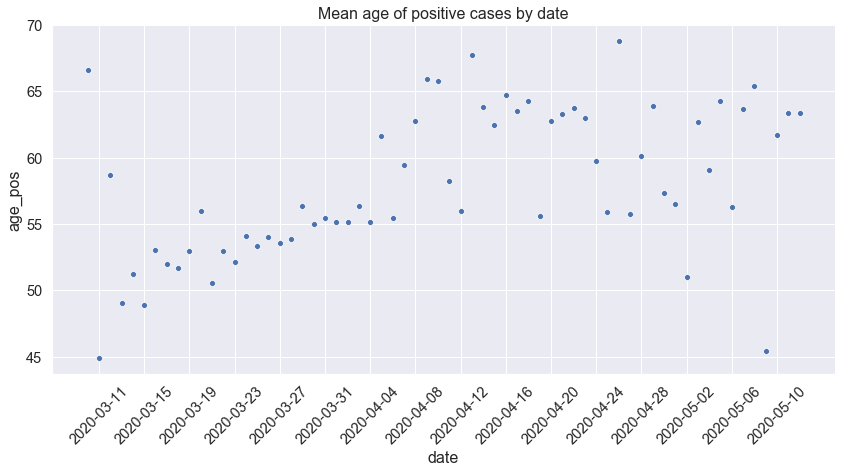

In [11]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

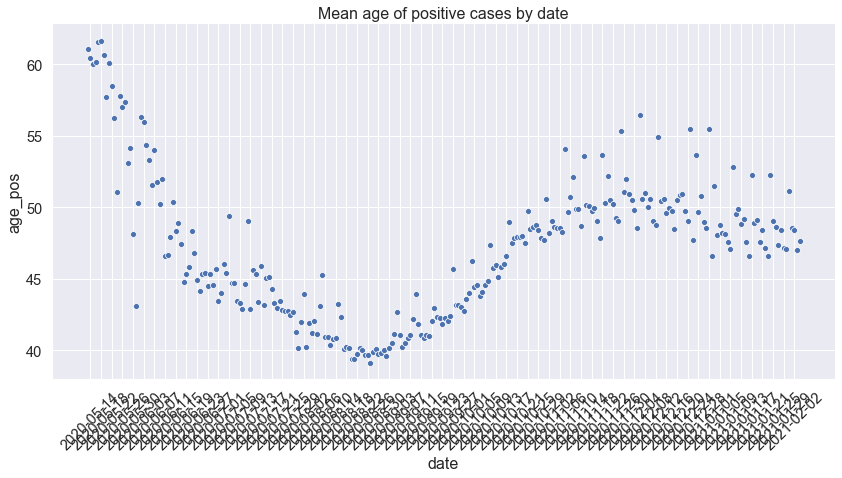

In [12]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

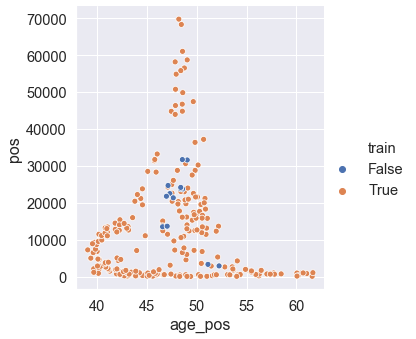

In [13]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

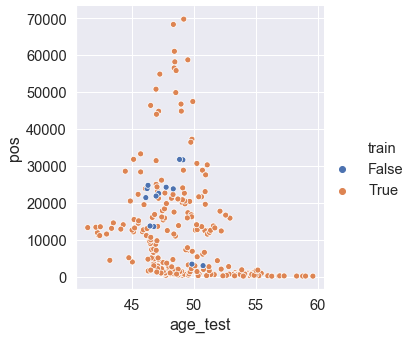

In [14]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

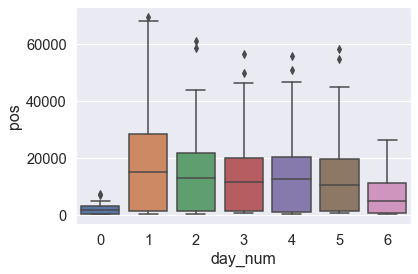

In [15]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [16]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

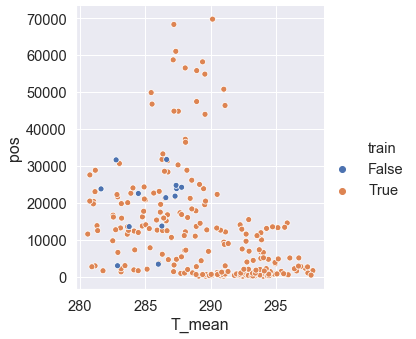

In [17]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

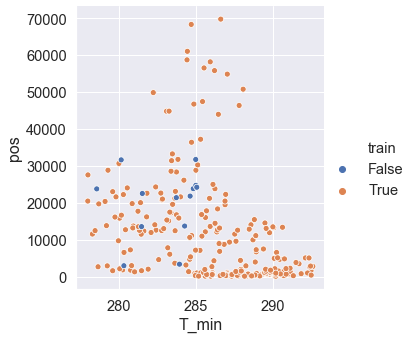

In [18]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

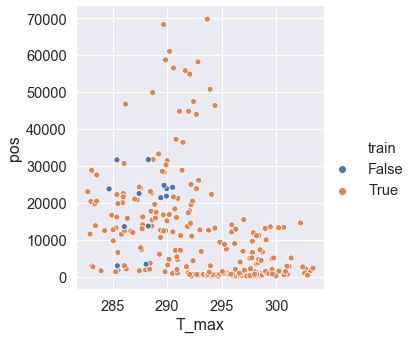

In [19]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

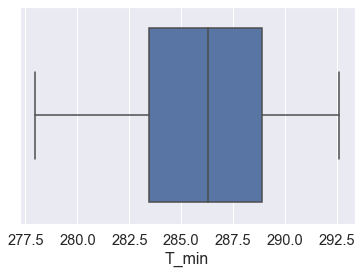

In [20]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [21]:
df_feat_fr["T_min"].mean()

285.99919905819416

In [22]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    143
True     125
Name: T_min, dtype: int64

In [23]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     134
False    134
Name: T_min, dtype: int64

In [24]:
df_feat_fr["T_min"].median()

286.2966666666667

In [25]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

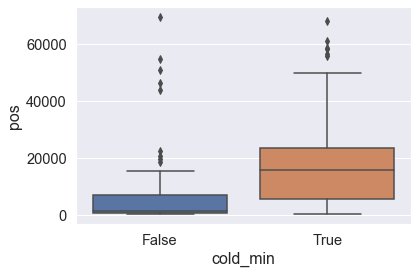

In [26]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

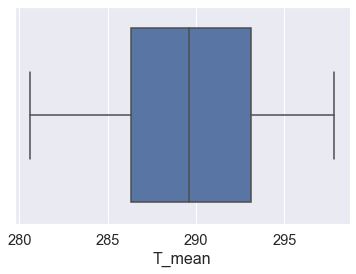

In [27]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [28]:
df_feat_fr["T_mean"].median()

289.61254088611355

In [29]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

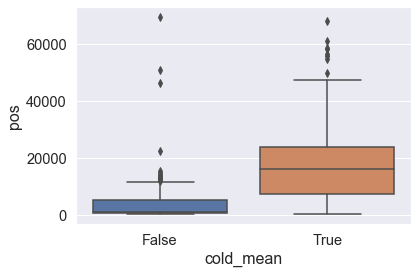

In [30]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

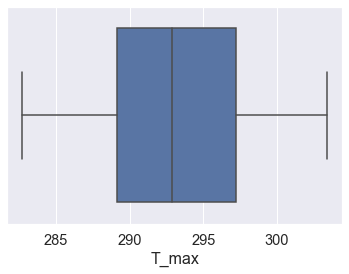

In [31]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [32]:
df_feat_fr["T_max"].median()

292.88220338983047

In [33]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

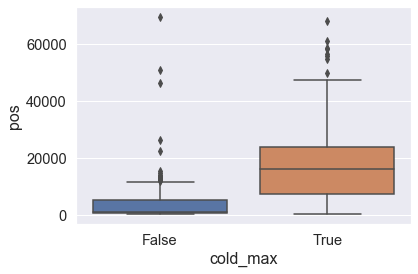

In [34]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [35]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

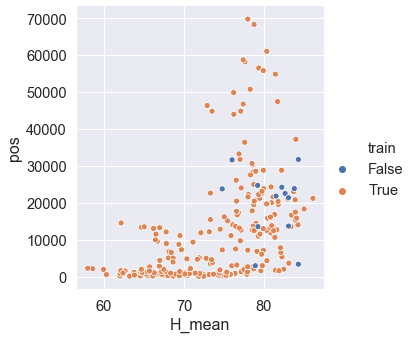

In [36]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

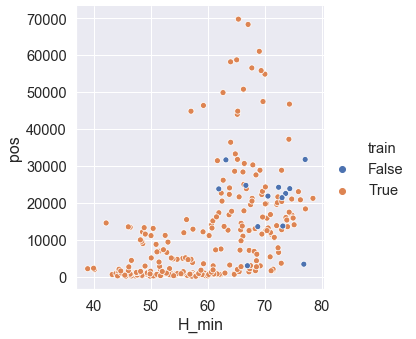

In [37]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

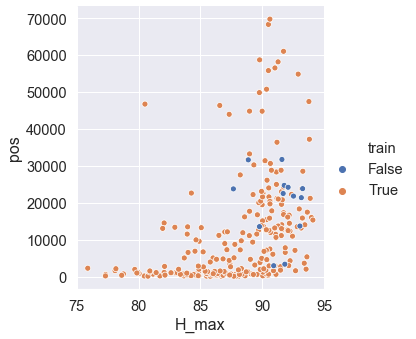

In [38]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

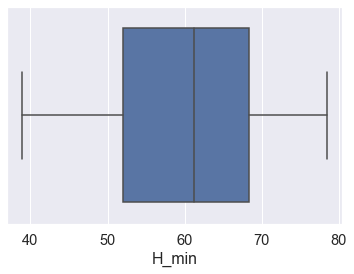

In [39]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [40]:
df_feat_fr["H_min"].median()

61.22556497175141

In [41]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

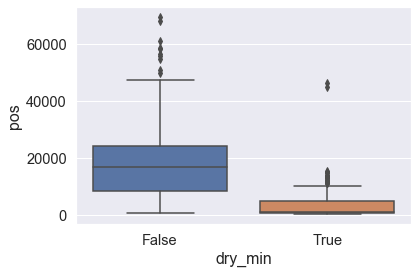

In [42]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

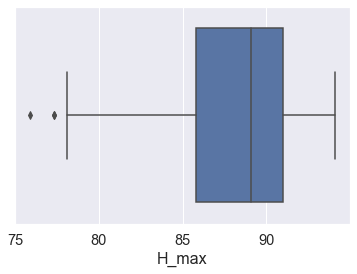

In [43]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [44]:
df_feat_fr["H_max"].median()

89.05961426066628

In [45]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

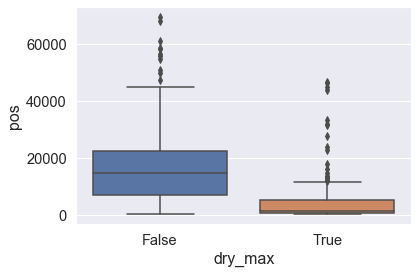

In [46]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

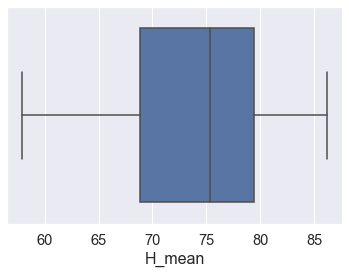

In [47]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [48]:
df_feat_fr["H_mean"].median()

75.31958128078817

In [49]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

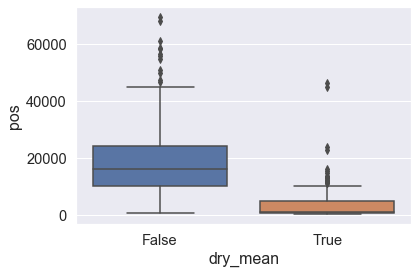

In [50]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [51]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

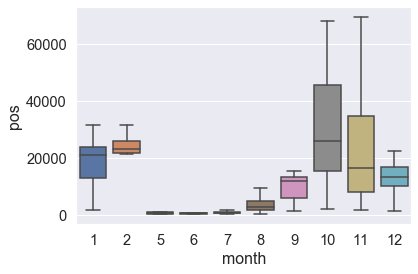

In [52]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

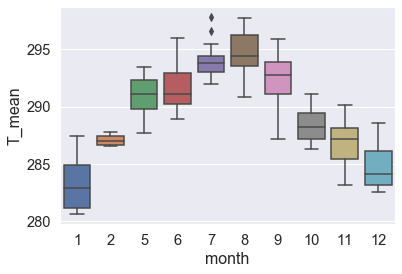

In [53]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

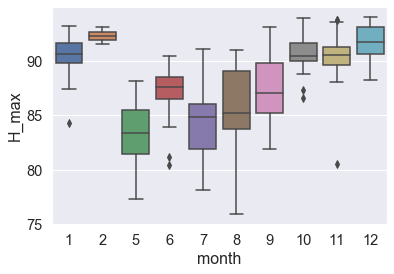

In [54]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [55]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1      558120
2       99112
5       11842
6       14892
7       24762
8      105833
9      293344
10     932646
11     671110
12     395860

### Nb Tested

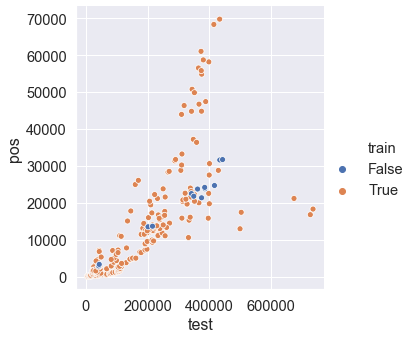

In [56]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [57]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [58]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [59]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [60]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    881   39048   
2020-05-14  285.050000  290.963333  59.406780  84.847458    979   41986   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   47686   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16535   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6604   
...                ...         ...        ...        ...    ...     ...   
2021-01-31  283.925000  288.071667  76.833333  91.816667   3368   44079   
2021-02-01  284.981667  288.285000  77.066667  91.583333  31727  442330   
2021-02-02  285.051667  290.508333  72.416667  92.083333  24200  384619   
2021-02-03  284.618333  289.940000  70.550000  92.516667  21804  349340   
2021-02-04  283.720000  289.425000  73.016667  93.150000  21381  374503   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.023837  55.435003  
2020-05-14        4  60.426966  54.831611  
2020-05-15        5  60.042116  54.385124  
2020-05-16        6  60.158076  54.486302  
2020-05-17        0  61.568345  58.291036  
...             ...        ...        ...  
2021-01-31        0  51.137767  49.831167  
2021-02-01        1  48.570681  48.834680  
2021-02-02        2  48.406736  47.749391  
2021-02-03        3  46.978307  46.935510  
2021-02-04        4  47.662644  46.107908  

[268 rows x 9 columns]

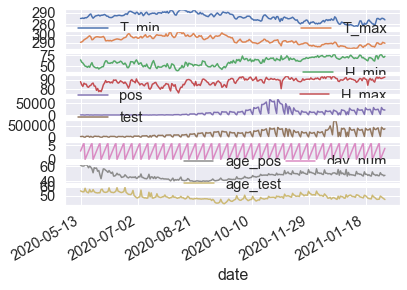

In [61]:
features.plot(subplots=True);

In [62]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [63]:
dataset.shape

(268, 9)

## Multi-step model

### Helper functions

In [64]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [65]:
TRAIN_SPLIT

254

In [66]:
dataset.shape

(268, 9)

In [67]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [68]:
y_train_multi.shape

(240, 7)

In [69]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target future to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

240 Single window of past history : (14, 9)

 240 Target future to predict : (7,)


In [70]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 240
BUFFER_SIZE : 254

For validation : 
BATCH_SIZE_VAL : 7


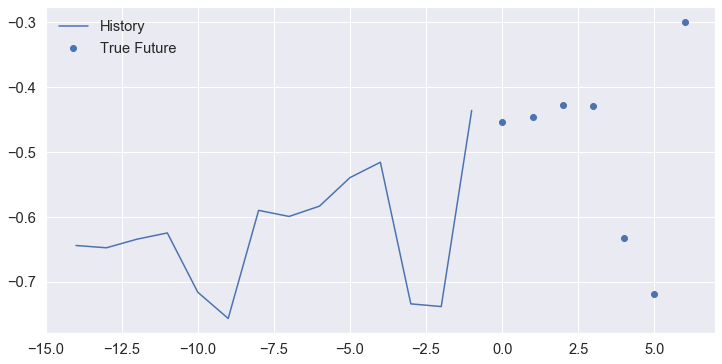

In [71]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [73]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 240
nb samples for validation : 7


In [74]:
x_train_multi.shape[-2:]

(14, 9)

In [93]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        dilations = [1, 2, 4])(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 20, 64), (None, 2 8576      
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, 20, 64), (None, 2 16512     
_________________________________________________________________
lambda_3 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
__________________________________________________

In [94]:
tcn_full_summary(m, expand_residual_blocks=True)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 20, 64)            128       
_________________________________________________________________
activation_51 (Activation)   (None, 20, 64)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 20, 64)            192       
_________________________________________________________________
activation_48 (Activation)   (None, 20, 64)            0         
_________________________________________________________________
spatial_dropout1d_24 (Spatia (None, 20, 64)            0         
_________________________________________________________________
conv1D_1 (Conv1D)            (None, 20, 64)           

In [106]:



lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 250 # 30

sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

out_tcn = TCN(return_sequences=False,
        dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
multi_step_model.compile(optimizer=sgd_2, loss='mae')

tcn_full_summary(multi_step_model, expand_residual_blocks=False)


'''# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(Conv1D(filters=1, 
                            kernel_size=2, 
                            padding='causal',
                            dilation_rate=2, 
                            activation=None,
                            input_shape=x_train_multi.shape[-2:],
                        kernel_initializer=tf.keras.initializers.Constant(1.),
                           use_bias=False))'''

#x = Conv1D(filters, kernel_size, strides=1, padding='causal', data_format='channels_last',
#    dilation_rate=1, groups=1, activation=None)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 14, 9)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, 14, 64), (None, 1 10112     
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 14, 64), (None, 1 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, 14, 64), (None, 1 16512     
_________________________________________________________________
lambda_7 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 43,591
Trainable params: 43,591
Non-trainable params: 0
_________________________________________________

"# create model\nmulti_step_model = tf.keras.models.Sequential()\nmulti_step_model.add(Conv1D(filters=1, \n                            kernel_size=2, \n                            padding='causal',\n                            dilation_rate=2, \n                            activation=None,\n                            input_shape=x_train_multi.shape[-2:],\n                        kernel_initializer=tf.keras.initializers.Constant(1.),\n                           use_bias=False))"


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00710: early stopping
Run #0 : val_loss = 0.24649128317832947


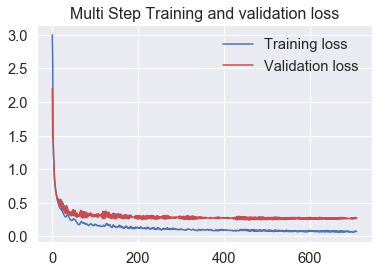

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00691: early stopping
Run #1 : val_loss = 0.21120956540107727


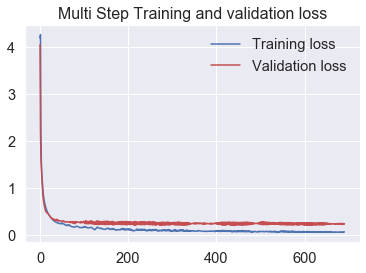

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00536: early stopping
Run #2 : val_loss = 0.23959289491176605

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00640: early stopping
Run #3 : val_loss = 0.33593323826789856

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01620: early stopping
Run #4 : val_loss = 0.22678855061531067

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01208: early stopping
Run #5 : val_loss = 0.2535524368286133

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00687: early stopping
Run #6 : val_loss = 0.2616378664970398

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00819: early stopping
Run #7 : val_loss = 0.295463889837265

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00373: early stopping
Run #8 : val_loss = 0.2868900001049042

 Run #9

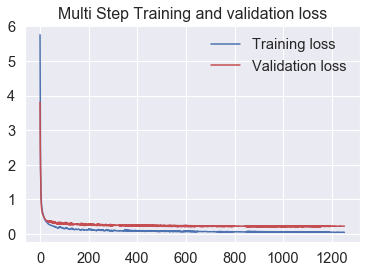

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #12
Restoring model weights from the end of the best epoch.
Epoch 00764: early stopping
Run #12 : val_loss = 0.20970876514911652

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 00686: early stopping
Run #13 : val_loss = 0.2532128691673279

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 00551: early stopping
Run #14 : val_loss = 0.263528048992157

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 00601: early stopping
Run #15 : val_loss = 0.25251221656799316

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00691: early stopping
Run #16 : val_loss = 0.21665875613689423

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00885: early stopping
Run #17 : val_loss = 0.21918630599975586

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00805: early stopping
Run #18 : val_loss = 0.2069087922

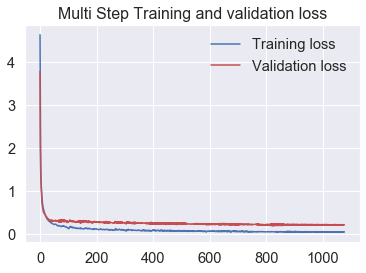

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #29
Restoring model weights from the end of the best epoch.
Epoch 00957: early stopping
Run #29 : val_loss = 0.27089181542396545

 Run #30
Restoring model weights from the end of the best epoch.
Epoch 03091: early stopping
Run #30 : val_loss = 0.22322598099708557

 Run #31
Restoring model weights from the end of the best epoch.
Epoch 00957: early stopping
Run #31 : val_loss = 0.2329796701669693

 Run #32
Restoring model weights from the end of the best epoch.
Epoch 00753: early stopping
Run #32 : val_loss = 0.24372564256191254

 Run #33
Restoring model weights from the end of the best epoch.
Epoch 00643: early stopping
Run #33 : val_loss = 0.19817259907722473


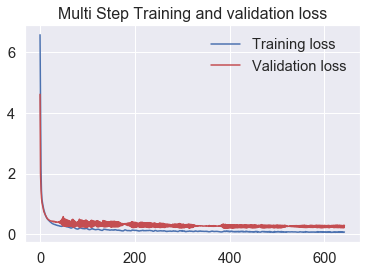

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #34
Restoring model weights from the end of the best epoch.
Epoch 01043: early stopping
Run #34 : val_loss = 0.2586595118045807

 Run #35
Restoring model weights from the end of the best epoch.
Epoch 00434: early stopping
Run #35 : val_loss = 0.27099499106407166

 Run #36
Restoring model weights from the end of the best epoch.
Epoch 00539: early stopping
Run #36 : val_loss = 0.25941112637519836

 Run #37
Restoring model weights from the end of the best epoch.
Epoch 00574: early stopping
Run #37 : val_loss = 0.19544410705566406


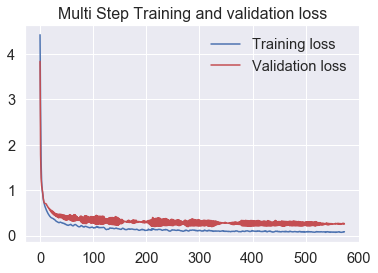

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #38
Restoring model weights from the end of the best epoch.
Epoch 00644: early stopping
Run #38 : val_loss = 0.2332892119884491

 Run #39
Restoring model weights from the end of the best epoch.
Epoch 00406: early stopping
Run #39 : val_loss = 0.26567211747169495

 Run #40
Restoring model weights from the end of the best epoch.
Epoch 00699: early stopping
Run #40 : val_loss = 0.2008185237646103

 Run #41
Restoring model weights from the end of the best epoch.
Epoch 00718: early stopping
Run #41 : val_loss = 0.21058662235736847

 Run #42
Restoring model weights from the end of the best epoch.
Epoch 00344: early stopping
Run #42 : val_loss = 0.2709571123123169

 Run #43
Restoring model weights from the end of the best epoch.
Epoch 00486: early stopping
Run #43 : val_loss = 0.26466187834739685

 Run #44
Restoring model weights from the end of the best epoch.
Epoch 00594: early stopping
Run #44 : val_loss = 0.2492669671

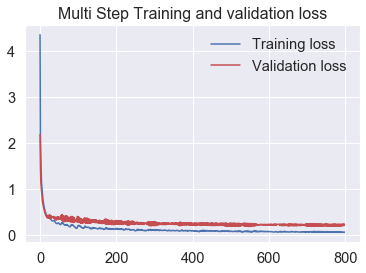

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #55
Restoring model weights from the end of the best epoch.
Epoch 01551: early stopping
Run #55 : val_loss = 0.2001246213912964

 Run #56
Restoring model weights from the end of the best epoch.
Epoch 00608: early stopping
Run #56 : val_loss = 0.27855294942855835

 Run #57
Restoring model weights from the end of the best epoch.
Epoch 00556: early stopping
Run #57 : val_loss = 0.21827638149261475

 Run #58
Restoring model weights from the end of the best epoch.
Epoch 00316: early stopping
Run #58 : val_loss = 0.29956135153770447

 Run #59
Restoring model weights from the end of the best epoch.
Epoch 00513: early stopping
Run #59 : val_loss = 0.30396610498428345

 Run #60
Restoring model weights from the end of the best epoch.
Epoch 01244: early stopping
Run #60 : val_loss = 0.22709964215755463

 Run #61
Restoring model weights from the end of the best epoch.
Epoch 00800: early stopping
Run #61 : val_loss = 0.23018744

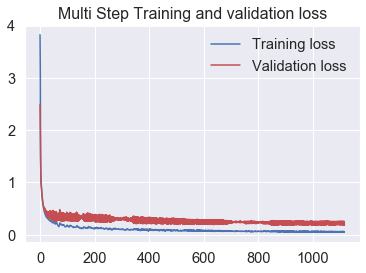

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr/assets

 Run #82
Restoring model weights from the end of the best epoch.
Epoch 01079: early stopping
Run #82 : val_loss = 0.2498147040605545

 Run #83
Restoring model weights from the end of the best epoch.
Epoch 01540: early stopping
Run #83 : val_loss = 0.1890045553445816

 Run #84
Restoring model weights from the end of the best epoch.
Epoch 00459: early stopping
Run #84 : val_loss = 0.22052523493766785

 Run #85
Restoring model weights from the end of the best epoch.
Epoch 01379: early stopping
Run #85 : val_loss = 0.23728272318840027

 Run #86
Restoring model weights from the end of the best epoch.
Epoch 00350: early stopping
Run #86 : val_loss = 0.25781676173210144

 Run #87
Restoring model weights from the end of the best epoch.
Epoch 00389: early stopping
Run #87 : val_loss = 0.27620401978492737

 Run #88
Restoring model weights from the end of the best epoch.
Epoch 00352: early stopping
Run #88 : val_loss = 0.213644161

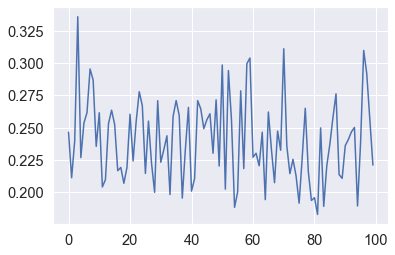

In [144]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 100 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2 : err=1.23 mais diverge
    # lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
    # lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
    # lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
    # lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
    # lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
    # lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
    # lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
    # lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
    # Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
    # Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
    # Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        
        '''multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))'''
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


### Eval

In [178]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [179]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

CPU times: user 1.67 s, sys: 1.02 s, total: 2.7 s
Wall time: 3.38 s


In [180]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  2587.285095720079
Mean nb cases  [nb of cases]:  20468.897959183672
mean relative error [%]:  12.640080090678529


In [147]:
multi_step_model.predict(x_val_multi)

array([[ 1.1307687 ,  0.21950054, -0.86565214,  1.8269558 ,  1.1262877 ,
         1.0091594 ,  0.9287528 ],
       [ 0.3177967 , -0.89444166,  0.9820527 ,  0.8908256 ,  0.9333887 ,
         0.9876062 ,  0.84008706],
       [-0.986101  ,  1.699017  ,  1.02854   ,  0.6906795 ,  0.5148643 ,
         0.994865  , -0.10341536],
       [ 1.5465398 ,  0.7682173 ,  0.8574183 ,  1.2917609 ,  1.0985395 ,
         0.3151669 , -0.6281542 ],
       [ 0.8367282 ,  0.7314182 ,  1.0390304 ,  1.0993953 ,  0.04581744,
        -0.6739141 ,  1.8241211 ],
       [ 1.0206708 ,  0.8448821 ,  0.90921843, -0.07009032, -0.5176144 ,
         1.563847  ,  1.3159459 ],
       [ 1.1541494 ,  0.41734594,  0.28731117, -0.29264247,  1.5003117 ,
         1.0963304 ,  0.90336597]], dtype=float32)

In [148]:
y_val_multi_pred.shape[0]

7

In [149]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

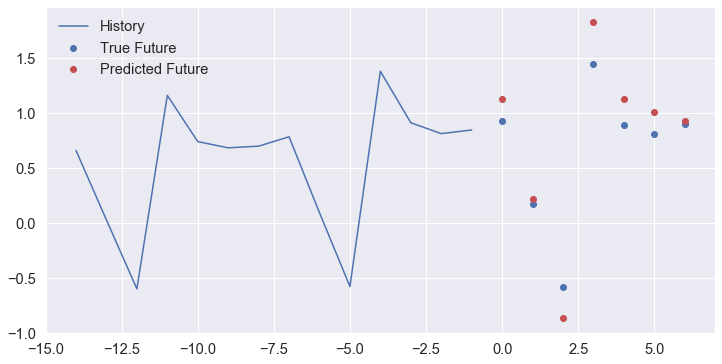

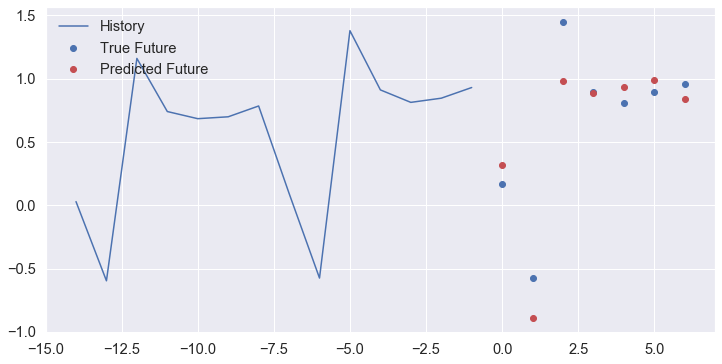

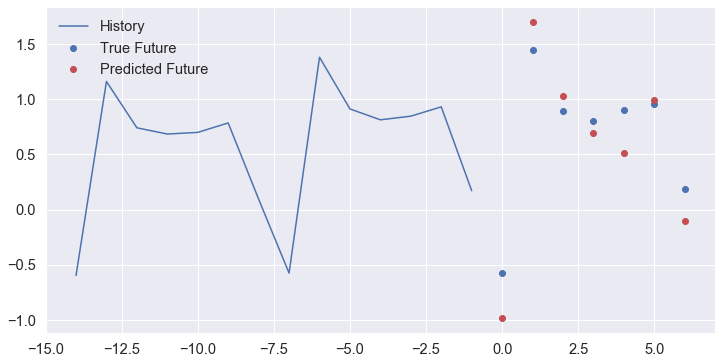

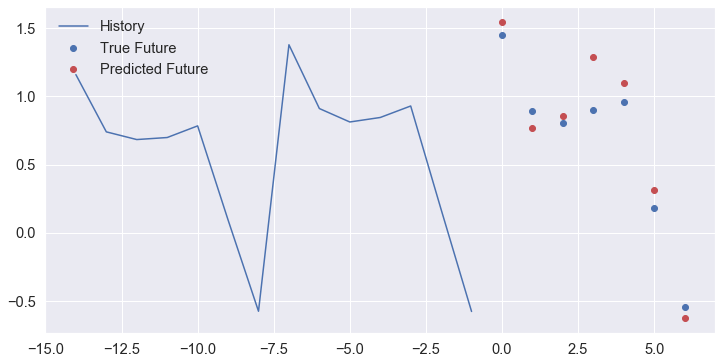

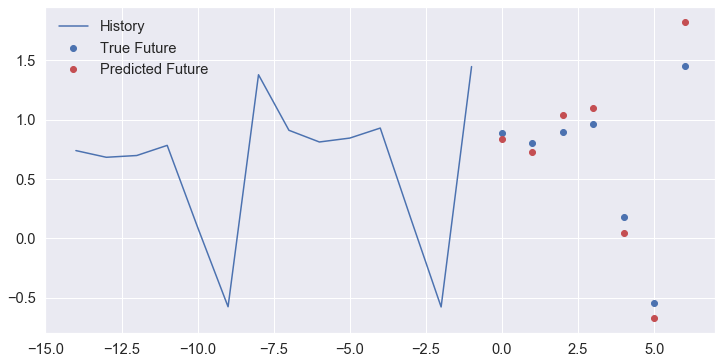

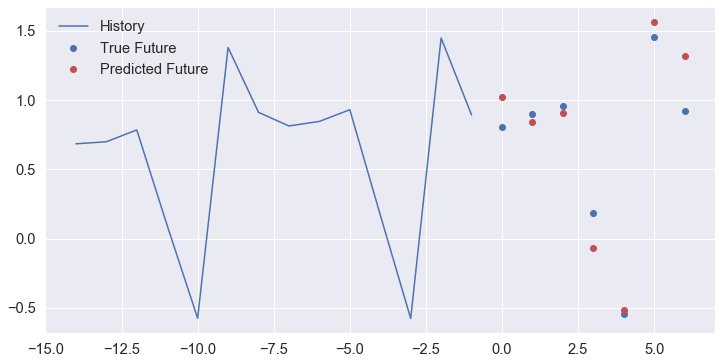

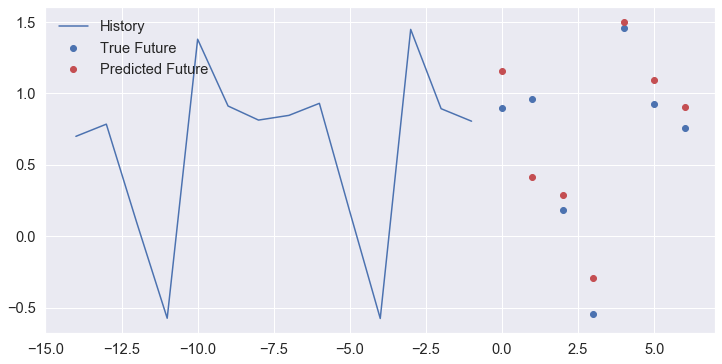

In [150]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [151]:
nb_period_plot = 9 #23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [152]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [153]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [154]:
TRAIN_SPLIT

254

In [155]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [156]:
df_feat_fr.shape

(268, 15)

In [157]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 136 ms, sys: 6.34 ms, total: 142 ms
Wall time: 163 ms


In [158]:
df_feat_fr.date.min()

'2020-05-13'

In [159]:
df_feat_fr.date.max()

'2021-02-04'

In [160]:
df_feat_fr.pos.std()

14090.817605738357

In [161]:
data_std[4]

14154.656341962027

In [162]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-12-03'

In [163]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2021-02-05  2021-02-05  19392   3267140
2021-02-06  2021-02-06  10215   3277355
2021-02-07  2021-02-07   3447   3280802
2021-02-08  2021-02-08  28231   3309033
2021-02-09  2021-02-09  26459   3335492
2021-02-10  2021-02-10  21799   3357291
2021-02-11  2021-02-11  17382   3374673

In [164]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2021-01-22'

In [165]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-12-03  282.076667  2020-12-03  286.855000  71.000000  90.650000     0.0   
2020-12-04  281.323333  2020-12-04  286.103333  70.200000  90.533333     0.0   
2020-12-05  280.316102  2020-12-05  285.492373  72.416667  91.850000     0.0   
2020-12-06  280.743220  2020-12-06  285.511017  71.466667  91.466667     0.0   
2020-12-07  280.146667  2020-12-07  284.930000  74.750000  92.166667     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-01-31  283.925000  2021-01-31  288.071667  76.833333  91.816667     0.0   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-12-03  11950  50.516736  198756  51.251308        4   2230439   153425.0   
2020-12-04  12526  49.829076  217199  51.341949        5   2242965   149773.0   
2020-12-05   6555  48.565370  104715  50.840835        6   2249520   149086.0   
2020-12-06   1754  56.467503   26135  55.158944        0   2251274   149014.0   
2020-12-07  16642  50.580099  255285  52.557875        1   2267916   147951.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-01-31   3368  51.137767   44079  49.831167        0   3148636   284658.0   
2021-02-01  31727  48.570681  442330  48.834680        1   3180363   285741.0   
2021-02-02  24200  48.406736  384619  47.749391        2   3204563   285920.0   
2021-02-03  21804  46.978307  349340  46.935510        3   3226367   285098.0   
2021-02-04  21381  47.662644  374503  46.107908        4   3247748   283386.0   

                  Rt  rate_pos  
date                            
2020-12-03  0.477000  6.012397  
2020-12-04  0.511148  5.767062  
2020-12-05  0.527852  6.259848  
2020-12-06  0.532267  6.711307  
2020-12-07  0.591206  6.518989  
...              ...       ...  
2021-01-31  1.115650  7.640827  
2021-02-01  1.111893  7.172699  
2021-02-02  1.108234  6.291941  
2021-02-03  1.095448  6.241484  
2021-02-04  1.074832  5.709167  

[64 rows x 15 columns]

### Figure

In [166]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [167]:
nb_period_plot

9

In [168]:
19*7

133

In [169]:
179-4*7

151

In [170]:
dataset.shape

(268, 9)

In [171]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[191 - 205]
[198 - 212]
[205 - 219]
[212 - 226]
[219 - 233]
[226 - 240]
[233 - 247]
[240 - 254]
[247 - 261]
9
CPU times: user 392 ms, sys: 18.3 ms, total: 410 ms
Wall time: 463 ms


array([[12036.98  ,  6176.24  ,  1885.0244, 15379.68  , 11571.342 ,
        12390.935 , 12064.277 , 12668.658 ,  7256.29  ,  1646.3428,
        18369.512 , 15157.781 , 13457.768 , 14547.542 , 16998.383 ,
        10269.219 ,  3093.1914, 20129.54  , 16907.777 , 15569.342 ,
        11317.76  ,   718.1113,  9243.499 ,  2152.2412, 20613.602 ,
        18771.916 , 18061.162 , 14075.504 ,  1476.5293, 12513.462 ,
         1975.3799, 27396.254 , 21077.93  , 19330.57  , 17664.27  ,
        18654.072 , 10278.357 ,  2382.0605, 26295.754 , 20266.52  ,
        19527.188 , 20534.615 , 20498.55  , 11529.589 ,  2346.1729,
        29227.363 , 22676.725 , 20730.008 , 21045.26  , 27124.283 ,
        14225.6   , -1134.3701, 36978.574 , 27060.855 , 25402.945 ,
        24264.818 , 28349.5   , 13294.375 ,  1969.085 , 28107.309 ,
        33347.6   , 37178.074 , 24489.137 ]], dtype=float32)

In [172]:
y_pos_pred.shape

(1, 63)

In [173]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-12-03
2021-02-04


date    pos  nb_cases
2020-12-04  2020-12-04  12036   2242475
2020-12-05  2020-12-05   6176   2248651
2020-12-06  2020-12-06   1885   2250536
2020-12-07  2020-12-07  15379   2265915
2020-12-08  2020-12-08  11571   2277486
...                ...    ...       ...
2021-01-31  2021-01-31   1969   3150470
2021-02-01  2021-02-01  28107   3178577
2021-02-02  2021-02-02  33347   3211924
2021-02-03  2021-02-03  37178   3249102
2021-02-04  2021-02-04  24489   3273591

[63 rows x 3 columns]

### Figure all past 

In [174]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [175]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [176]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()